In [1]:
#Import modules and create the neural network
import torch
import torch.nn as nn
import crypten
import io
import pickle

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(2, 1)  # Example model

    def forward(self, x):
        x = self.fc(x)
        return x


In [2]:
def measure_data_size(data):
    """
    Serialize data to bytes and measure its size.
    Args:
    - data (Any): The data to measure.
    Returns:
    - int: Size of the data in bytes.
    """
    buffer = io.BytesIO()
    torch.save(data, buffer)
    size_in_bytes = buffer.tell()  # Get the size of the buffer
    return size_in_bytes

In [3]:
#Create two models instances (two parties)
model_a = SimpleModel()
model_b = SimpleModel()

size_before_a = measure_data_size(model_a.state_dict())
size_before_b = measure_data_size(model_b.state_dict())


# Simulate the training Process (We can manually adjusting model weights for demonstration)
with torch.no_grad():
    model_a.fc.weight.fill_(10.0)
    model_a.fc.bias.fill_(2.0)
    
    model_b.fc.weight.fill_(2.0)
    model_b.fc.bias.fill_(4.0)


In [4]:
#Create CrypTen Instance and encrypt the weights
crypten.init()

def encrypt_model_parameters(model):
    encrypted_params = []
    for param in model.parameters():
        encrypted_param = crypten.cryptensor(param.data)
        encrypted_params.append(encrypted_param)
        size_in_bytes = measure_data_size(encrypted_params)
    return encrypted_params, size_in_bytes




In [5]:
#Aggregate the encrypted weights (simulating the aggregator entity)
def aggregate_encrypted_parameters(encrypted_params_list):
    aggregated_params = []
    for params_tuple in zip(*encrypted_params_list):
        # Securely sum the parameters and divide by the number of models to get the average
        sum_params = sum(params_tuple)
        avg_params = sum_params / len(params_tuple)
        aggregated_params.append(avg_params)
    return aggregated_params



In [6]:
#Decrypt the weights and update the global model (simulating the global model manager entity)

def update_global_model_with_decrypted_params(global_model, aggregated_encrypted_params):
    """
    Updates the global model's parameters with decrypted values of the aggregated encrypted parameters.
    
    Args:
    - global_model (torch.nn.Module): The model to update.
    - aggregated_encrypted_params (list): A list of aggregated encrypted model parameters.
    """
    with torch.no_grad():
        for param, aggregated_encrypted_param in zip(global_model.parameters(), aggregated_encrypted_params):
            # Decrypt the aggregated encrypted parameter
            decrypted_aggregated_param = aggregated_encrypted_param.get_plain_text()
            param.copy_(decrypted_aggregated_param)


In [7]:
global_model = SimpleModel()
size_before_global_before = measure_data_size(global_model.state_dict())

encrypted_params_a, size_after_a = encrypt_model_parameters(model_a)
encrypted_params_b, size_after_b = encrypt_model_parameters(model_b)
aggregated_encrypted_params = aggregate_encrypted_parameters([encrypted_params_a, encrypted_params_b])
update_global_model_with_decrypted_params(global_model, aggregated_encrypted_params)


In [8]:
print(f"Data size before encryption: {size_before_a} bytes")
print(f"Data size after encryption: {size_after_a} bytes")

Data size before encryption: 1496 bytes
Data size after encryption: 2008 bytes


In [9]:
print(f"Data size before encryption: {size_before_b} bytes")
print(f"Data size after encryption: {size_after_b} bytes")

Data size before encryption: 1496 bytes
Data size after encryption: 2008 bytes


In [10]:
#Check the encrypted aggregated parameters
aggregated_encrypted_params

[MPCTensor(
 	_tensor=tensor([[393216, 393216]])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 ),
 MPCTensor(
 	_tensor=tensor([196608])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 )]

In [42]:
#Check the parameters of the global model
for name, param in global_model.named_parameters():
    print(f"{name}: {param.data}")

fc.weight: tensor([[6., 6.]])
fc.bias: tensor([3.])


In [11]:
import time
import psutil
import os

# Function to measure CPU and Memory Usage
def measure_resource_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    cpu_usage = py.cpu_percent()
    memory_use = py.memory_info()[0] / 2. ** 30  # Memory usage in GB
    return cpu_usage, memory_use

# Wrap your aggregation function call with timing and resource measurement
start_time = time.time()
cpu_before, mem_before = measure_resource_usage()

# Secure aggregation function calls 
encrypted_params_a, size_after_a = encrypt_model_parameters(model_a)
encrypted_params_b, size_after_b = encrypt_model_parameters(model_b)
aggregated_encrypted_params = aggregate_encrypted_parameters([encrypted_params_a, encrypted_params_b])
update_global_model_with_decrypted_params(global_model, aggregated_encrypted_params)

cpu_after, mem_after = measure_resource_usage()
end_time = time.time()

# Calculate and print the results
print(f"Execution time: {end_time - start_time} seconds")
print(f"CPU usage before: {cpu_before}%, after: {cpu_after}%")
print(f"Memory usage before: {mem_before}GB, after: {mem_after}GB")


Execution time: 0.003624439239501953 seconds
CPU usage before: 0.0%, after: 0.0%
Memory usage before: 0.49047088623046875GB, after: 0.49047088623046875GB


In [ ]:
###### More Complex Example

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [13]:
# Example dataset (Dumpy Data)
data = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]], requires_grad=True)
targets = torch.tensor([[0.], [1.], [0.], [1.]], requires_grad=False)

# Split the dataset between parties
data_alice, targets_alice = data[:2], targets[:2]
data_bob, targets_bob = data[2:], targets[2:]


In [14]:
#Training loop for each party (local training)
def train_local_model(data, targets):
    model = SimpleModel()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    epochs = 5

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    
    return model


In [15]:
#Simulate the training process at each party
model_alice = train_local_model(data_alice, targets_alice)
model_bob = train_local_model(data_bob, targets_bob)

size_before_alice = measure_data_size(model_alice.state_dict())
size_before_bob = measure_data_size(model_bob.state_dict())


In [ ]:
##### With Secure aggregation

In [16]:
#Encrypt the weights of each party
encrypted_params_alica, size_after_alica = encrypt_model_parameters(model_alice)
encrypted_params_bob, size_after_bob = encrypt_model_parameters(model_bob)


In [17]:
#Aggregate the encrypted weights (simulating the aggregator entity)
aggregated_encrypted_params = aggregate_encrypted_parameters([encrypted_params_alica, encrypted_params_bob])

In [18]:
#Decrypt the weights and update the global model (simulating the global model manager)

global_model_S = SimpleModel()

update_global_model_with_decrypted_params(global_model_S, aggregated_encrypted_params)


In [19]:
#Check the encrypted aggregated parameters
aggregated_encrypted_params

[MPCTensor(
 	_tensor=tensor([[ 33427, -18915],
         [  7249,  -6026],
         [-29328,  17418],
         [-22551, -14149]])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 ),
 MPCTensor(
 	_tensor=tensor([-12769,  -3638, -16040,  13388])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 ),
 MPCTensor(
 	_tensor=tensor([[  8407, -13001, -22342, -16156]])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 ),
 MPCTensor(
 	_tensor=tensor([-1849])
 	plain_text=HIDDEN
 	ptype=ptype.arithmetic
 )]

In [20]:
#Check the parameters of the global model

for name, param in global_model_S.named_parameters():
    print(f"{name}: {param.data}")


fc1.weight: tensor([[ 0.5101, -0.2886],
        [ 0.1106, -0.0919],
        [-0.4475,  0.2658],
        [-0.3441, -0.2159]])
fc1.bias: tensor([-0.1948, -0.0555, -0.2448,  0.2043])
fc2.weight: tensor([[ 0.1283, -0.1984, -0.3409, -0.2465]])
fc2.bias: tensor([-0.0282])


In [23]:
import time
import psutil
import os

# Function to measure CPU and Memory Usage
def measure_resource_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    cpu_usage = py.cpu_percent()
    memory_use = py.memory_info()[0] / 2. ** 30  # Memory usage in GB
    return cpu_usage, memory_use

# Wrap your aggregation function call with timing and resource measurement
start_time = time.time()
cpu_before, mem_before = measure_resource_usage()

# Place your secure aggregation function call here
# e.g., aggregate_encrypted_parameters(...)
encrypted_params_alica, size_after_alica = encrypt_model_parameters(model_alice)
encrypted_params_bob, size_after_bob = encrypt_model_parameters(model_bob)
aggregated_encrypted_params = aggregate_encrypted_parameters([encrypted_params_alica, encrypted_params_bob])
update_global_model_with_decrypted_params(global_model_S, aggregated_encrypted_params)

cpu_after, mem_after = measure_resource_usage()
end_time = time.time()

# Calculate and print the results
print(f"Execution time: {end_time - start_time} seconds")
print(f"CPU usage before: {cpu_before}%, after: {cpu_after}%")
print(f"Memory usage before: {mem_before}GB, after: {mem_after}GB")


Execution time: 0.0062160491943359375 seconds
CPU usage before: 0.0%, after: 0.0%
Memory usage before: 0.5342063903808594GB, after: 0.5342063903808594GB


In [24]:
print(f"Data size before encryption: {size_before_alice} bytes")
print(f"Data size after encryption: {size_after_alica} bytes")

Data size before encryption: 2064 bytes
Data size after encryption: 2704 bytes


In [25]:
print(f"Data size before encryption: {size_before_bob} bytes")
print(f"Data size after encryption: {size_after_bob} bytes")

Data size before encryption: 2064 bytes
Data size after encryption: 2704 bytes


0.005013928862516293


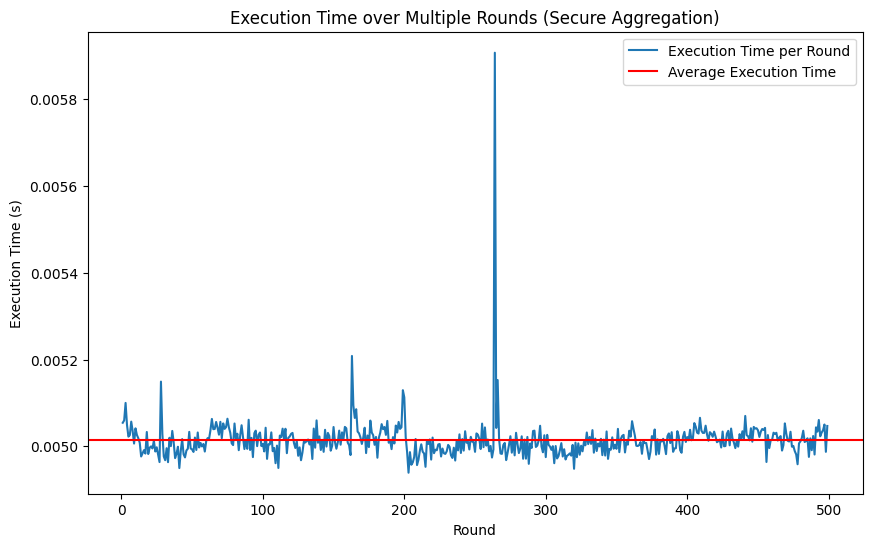

In [27]:
import time
import matplotlib.pyplot as plt

execution_times = []

# Execute the function multiple rounds and record execution time
for _ in range(500):  # Example: 10 rounds
    start_time = time.time()
    encrypted_params_alica, size_after_alica = encrypt_model_parameters(model_alice)
    encrypted_params_bob, size_after_bob = encrypt_model_parameters(model_bob) 
    aggregated_encrypted_params = aggregate_encrypted_parameters([encrypted_params_alica, encrypted_params_bob])
    update_global_model_with_decrypted_params(global_model_S, aggregated_encrypted_params)
    execution_times.append(time.time() - start_time)

# Calculate average execution time
average_execution_time = sum(execution_times[1:]) / len(execution_times[1:])
print (average_execution_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 500), execution_times[1:], label='Execution Time per Round')
plt.axhline(y=average_execution_time, color='r', linestyle='-', label='Average Execution Time')
plt.xlabel('Round')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time over Multiple Rounds (Secure Aggregation)')
plt.legend()
plt.show()

In [ ]:
#### Without the Secure Aggregation

In [28]:
#Aggregate the unencrypted weights (simulating the aggregator entity)

def aggregate_parameters_unsecure(model_alice, model_bob):
    
    state_dict_a = model_alice.state_dict()
    state_dict_b = model_bob.state_dict()

    aggregated_state_dict = {}
    for key in state_dict_a:
        aggregated_state_dict[key] = (state_dict_a[key] + state_dict_b[key]) / 2

    
    return aggregated_state_dict


In [29]:
#Update the global model (simulating the global model manager)

def update_model_unsecure(aggregated_state_dict):
    global_model_US = SimpleModel()
    global_model_US.load_state_dict(aggregated_state_dict)
    return global_model_US

In [35]:
import time
import psutil
import os

# Function to measure CPU and Memory Usage
def measure_resource_usage():
    pid = os.getpid()
    py = psutil.Process(pid)
    cpu_usage = py.cpu_percent()
    memory_use = py.memory_info()[0] / 2. ** 30  # Memory usage in GB
    return cpu_usage, memory_use

# Wrap your aggregation function call with timing and resource measurement
start_time = time.time()
cpu_before, mem_before = measure_resource_usage()

# Place your secure aggregation function call here
# e.g., aggregate_encrypted_parameters(...)
aggregated_state_dict = aggregate_parameters_unsecure(model_alice, model_bob)
global_model_US = update_model_unsecure(aggregated_state_dict)

cpu_after, mem_after = measure_resource_usage()
end_time = time.time()

# Calculate and print the results
print(f"Execution time: {end_time - start_time} seconds")
print(f"CPU usage before: {cpu_before}%, after: {cpu_after}%")
print(f"Memory usage before: {mem_before}GB, after: {mem_after}GB")


Execution time: 0.0009098052978515625 seconds
CPU usage before: 0.0%, after: 0.0%
Memory usage before: 0.5627708435058594GB, after: 0.5627708435058594GB


In [59]:
#Check the parameters of the global model

for name, param in global_model_US.named_parameters():
    print(f"{name}: {param.data}")


fc1.weight: tensor([[ 0.2407, -0.3058],
        [-0.2483,  0.2535],
        [-0.2970, -0.3935],
        [-0.0044, -0.1119]])
fc1.bias: tensor([ 0.0652,  0.0376, -0.1847,  0.2995])
fc2.weight: tensor([[ 0.0978,  0.2147, -0.1119,  0.1606]])
fc2.bias: tensor([-0.1020])


8.881211519719125e-05


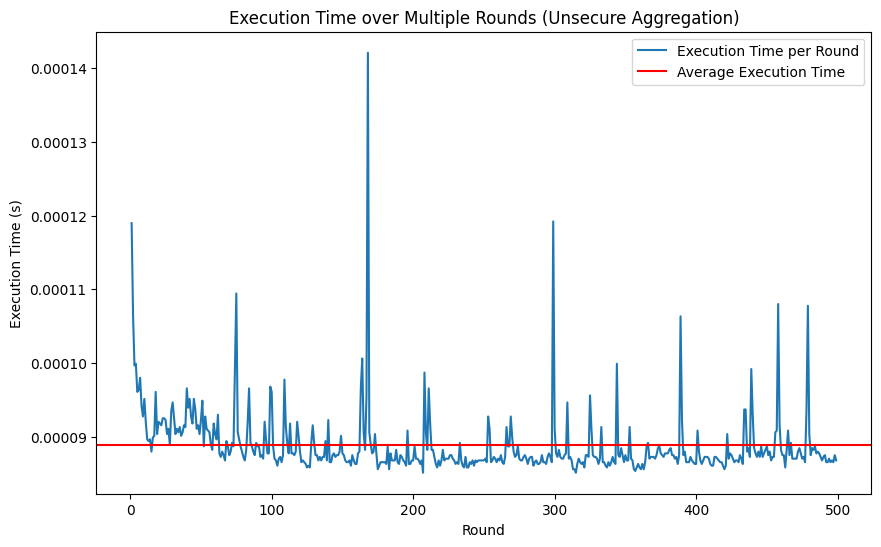

In [48]:
import time
import matplotlib.pyplot as plt

execution_times = []

# Execute the function multiple rounds and record execution time
for _ in range(500):  # Example: 10 rounds
    start_time = time.time()
    aggregated_state_dict = aggregate_parameters_unsecure(model_alice, model_bob)
    global_model_US = update_model_unsecure(aggregated_state_dict)
    execution_times.append(time.time() - start_time)

# Calculate average execution time
average_execution_time = sum(execution_times[1:]) / len(execution_times[1:])
print (average_execution_time)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 500), execution_times[1:], label='Execution Time per Round')
plt.axhline(y=average_execution_time, color='r', linestyle='-', label='Average Execution Time')
plt.xlabel('Round')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time over Multiple Rounds (Unsecure Aggregation)')
plt.legend()
plt.show()


In [67]:
execution_times[1:]

[0.00017952919006347656,
 0.0001590251922607422,
 0.00013375282287597656,
 0.00011587142944335938,
 9.560585021972656e-05,
 9.703636169433594e-05,
 9.465217590332031e-05,
 9.417533874511719e-05,
 9.369850158691406e-05,
 8.96453857421875e-05,
 9.655952453613281e-05,
 9.608268737792969e-05,
 9.298324584960938e-05,
 9.202957153320312e-05,
 8.797645568847656e-05,
 8.511543273925781e-05,
 8.678436279296875e-05,
 8.702278137207031e-05,
 8.7738037109375e-05,
 8.726119995117188e-05,
 8.535385131835938e-05,
 9.083747863769531e-05,
 8.58306884765625e-05,
 8.392333984375e-05,
 9.584426879882812e-05,
 8.821487426757812e-05,
 8.392333984375e-05,
 8.535385131835938e-05,
 8.487701416015625e-05,
 8.511543273925781e-05,
 8.296966552734375e-05,
 8.463859558105469e-05,
 8.630752563476562e-05,
 8.630752563476562e-05,
 8.606910705566406e-05,
 8.654594421386719e-05,
 8.511543273925781e-05,
 8.440017700195312e-05,
 8.249282836914062e-05,
 8.296966552734375e-05,
 8.487701416015625e-05,
 8.58306884765625e-05,


In [ ]:
# The average execution time for 500 rounds execution times
execution_time_1 = 0.0021860847970048983  #Secure
execution_time_2 = 8.19352442372538e-05   #Unsecure

# Determine the faster time and calculate the difference
faster_time = min(execution_time_1, execution_time_2)
difference = abs(execution_time_1 - execution_time_2)
percentage_difference = (difference / faster_time) * 100

faster_time, difference, percentage_difference


In [ ]:
####### End of Code #######